In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, column_name):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame[column_name]).toarray()
    return count_vectorizer,  fitted_and_transformed

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
def k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [8]:
from sklearn.manifold import TSNE
m = TSNE(perplexity=51, init='pca',early_exaggeration=4)
tsne_features = m.fit_transform(conv_ds2)
tsne_features

/Users/bhabaranjanpanigrahi/miniforge3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/bhabaranjanpanigrahi/miniforge3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


array([[ 0.4006295 ,  1.5461386 ],
       [ 0.9168318 , -1.9917066 ],
       [ 3.00785   ,  3.4149253 ],
       ...,
       [-1.4842106 ,  2.025946  ],
       [-0.27427223,  2.2754781 ],
       [ 2.924211  ,  1.8949068 ]], dtype=float32)

/Users/bhabaranjanpanigrahi/miniforge3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/bhabaranjanpanigrahi/miniforge3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


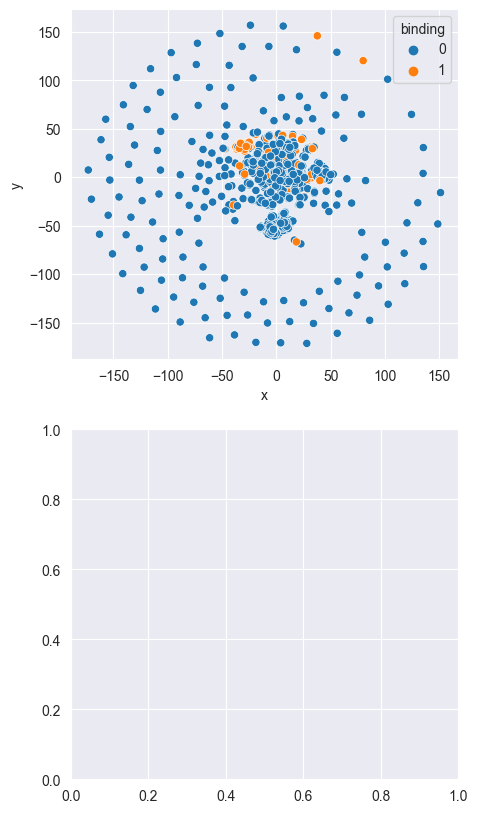

In [10]:
import seaborn as sns
from sklearn.manifold import TSNE
fig, ax = plt.subplots(2,1,figsize=(5,10))
for i in range(100,101):
    m = TSNE(perplexity=5,init='pca')
    tsne_features = m.fit_transform(conv_ds2)
    table['x'] = tsne_features[:,0]
    table['y'] = tsne_features[:,1]
    sns.scatterplot(x='x',y='y',hue='binding',data=table,ax=ax[i-100])